In [1]:
import torch
import torch.nn as nn
import numpy as np 
import os
import matplotlib.pyplot as plt
import cv2
import torchvision
import time
from tqdm import tqdm
import pandas as pd

from torch.utils.data import ConcatDataset
from torch.nn import functional as F
from torchvision.transforms import CenterCrop
from torch.nn import ConvTranspose2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Conv2d
from torch.nn import ModuleList
from torch.utils.data import Dataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from imutils import paths
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, jaccard_score

torch.manual_seed(101)
np.random.seed(101)


In [2]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 15
BATCH_SIZE = 32

# define the input image dimensions
INPUT_IMAGE_WIDTH = 224
INPUT_IMAGE_HEIGHT = 224

# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the path to the base output directory
BASE_OUTPUT = "output"

# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_val_64_40_salt.pth")
LAST_PATH = os.path.join(BASE_OUTPUT, "unet_val_64_40.pth")
NEW_PATH = os.path.join(BASE_OUTPUT, "unet_val_32_50_CUDA.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])


In [3]:
# determine the device to be used for training and evaluation
#DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

# determine if we will be pinning memory during data loading
#PIN_MEMORY = True if DEVICE == "mps" else False
#print(f'Current device is {DEVICE}')


In [4]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
print(f'Current device is {DEVICE}')

torch.cuda.get_arch_list()


Current device is cuda


['sm_37',
 'sm_50',
 'sm_60',
 'sm_61',
 'sm_70',
 'sm_75',
 'sm_80',
 'sm_86',
 'sm_90',
 'compute_37']

In [5]:
main_folder = '../Datasets/ham1000-segmentation-and-classification'

trainx_folder = os.path.join(main_folder, 'images/')
trainy_folder = os.path.join(main_folder, 'masks/')


In [6]:
trainx_paths = sorted(list(paths.list_images(trainx_folder)))
trainy_paths = sorted(list(paths.list_images(trainy_folder)))


In [7]:
x_train, x_val_test, y_train, y_val_test = train_test_split(trainx_paths, trainy_paths, test_size = 0.4, random_state = 101)


In [8]:
x_val, x_test, y_val, y_test =  train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state = 101)


In [9]:
augmentations = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)),
    torchvision.transforms.RandomRotation(180),
    torchvision.transforms.RandomHorizontalFlip(0.2),
    torchvision.transforms.ToTensor()])


In [10]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)),
    torchvision.transforms.ToTensor()])


In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        self.augmentations = augmentations
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        # return a tuple of the image and its mask
        return (image, mask)
    

In [12]:
# create the train and test datasets
trainDS_1 = SegmentationDataset(imagePaths=x_train, maskPaths=y_train,transforms=transforms)
trainDS_2 = SegmentationDataset(imagePaths=x_train, maskPaths=y_train,transforms=augmentations)
valDS_1 = SegmentationDataset(imagePaths=x_val, maskPaths=y_val,transforms=transforms)
valDS_2 = SegmentationDataset(imagePaths=x_val, maskPaths=y_val,transforms=augmentations)

trainDS = ConcatDataset([trainDS_1, trainDS_2])
valDS = ConcatDataset([valDS_1, valDS_2])


In [13]:
print(trainDS_1[0][0].shape)


torch.Size([3, 224, 224])


In [14]:
print(trainDS[0][0].shape)

torch.Size([3, 224, 224])


In [15]:
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(valDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=0)
testLoader = DataLoader(valDS, shuffle=False,batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=0)


[INFO] found 12014 examples in the training set...
[INFO] found 4006 examples in the test set...


In [16]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE
    

In [17]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice_loss
    

In [18]:
class Block(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

class Encoder(nn.Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
        
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
            # return the list containing the intermediate outputs
        return blockOutputs                        

class Decoder(nn.Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
             for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])
        
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
            # return the final decoder output
        return x
      
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

class UNet(nn.Module):
    def __init__(self,encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), 
                 nbClasses=1, retainDim=True, 
                 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
            
        # return the segmentation map    
        return map


In [19]:
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = DiceLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(valDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "validation_loss": []}
next(unet.parameters()).is_cuda
#next(unet.parameters()).is_mps

True

In [20]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalValLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["validation_loss"].append(avgValLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Validation loss: {:.4f}".format(avgTrainLoss, avgValLoss))
    # display the total time needed to perform the training
    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
    

[INFO] training the network...


  7%|█████▍                                                                            | 1/15 [03:54<54:40, 234.29s/it]

[INFO] EPOCH: 1/15
Train loss: 0.386627, Validation loss: 0.3266
[INFO] total time taken to train the model: 234.29s


 13%|██████████▉                                                                       | 2/15 [06:44<42:36, 196.62s/it]

[INFO] EPOCH: 2/15
Train loss: 0.332436, Validation loss: 0.3194
[INFO] total time taken to train the model: 404.55s


 20%|████████████████▍                                                                 | 3/15 [09:29<36:26, 182.21s/it]

[INFO] EPOCH: 3/15
Train loss: 0.323833, Validation loss: 0.3110
[INFO] total time taken to train the model: 569.60s


 27%|█████████████████████▊                                                            | 4/15 [12:11<31:58, 174.38s/it]

[INFO] EPOCH: 4/15
Train loss: 0.303930, Validation loss: 0.2905
[INFO] total time taken to train the model: 731.98s


 33%|███████████████████████████▎                                                      | 5/15 [14:54<28:22, 170.23s/it]

[INFO] EPOCH: 5/15
Train loss: 0.288889, Validation loss: 0.2795
[INFO] total time taken to train the model: 894.84s


 40%|████████████████████████████████▊                                                 | 6/15 [17:38<25:11, 167.91s/it]

[INFO] EPOCH: 6/15
Train loss: 0.286976, Validation loss: 0.2777
[INFO] total time taken to train the model: 1058.26s


 47%|██████████████████████████████████████▎                                           | 7/15 [20:12<21:46, 163.32s/it]

[INFO] EPOCH: 7/15
Train loss: 0.283542, Validation loss: 0.2809
[INFO] total time taken to train the model: 1212.12s


 53%|███████████████████████████████████████████▋                                      | 8/15 [22:53<18:57, 162.57s/it]

[INFO] EPOCH: 8/15
Train loss: 0.297271, Validation loss: 0.2749
[INFO] total time taken to train the model: 1373.09s


 60%|█████████████████████████████████████████████████▏                                | 9/15 [25:36<16:16, 162.80s/it]

[INFO] EPOCH: 9/15
Train loss: 0.278126, Validation loss: 0.2723
[INFO] total time taken to train the model: 1536.40s


 67%|██████████████████████████████████████████████████████                           | 10/15 [28:36<14:00, 168.13s/it]

[INFO] EPOCH: 10/15
Train loss: 0.282117, Validation loss: 0.2780
[INFO] total time taken to train the model: 1716.46s


 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [31:28<11:17, 169.48s/it]

[INFO] EPOCH: 11/15
Train loss: 0.280573, Validation loss: 0.2722
[INFO] total time taken to train the model: 1888.99s


 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [34:09<08:19, 166.64s/it]

[INFO] EPOCH: 12/15
Train loss: 0.275727, Validation loss: 0.2721
[INFO] total time taken to train the model: 2049.13s


 87%|██████████████████████████████████████████████████████████████████████▏          | 13/15 [36:46<05:27, 163.77s/it]

[INFO] EPOCH: 13/15
Train loss: 0.274548, Validation loss: 0.2765
[INFO] total time taken to train the model: 2206.29s


 93%|███████████████████████████████████████████████████████████████████████████▌     | 14/15 [39:19<02:40, 160.50s/it]

[INFO] EPOCH: 14/15
Train loss: 0.277999, Validation loss: 0.2773
[INFO] total time taken to train the model: 2359.25s


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [41:55<00:00, 167.70s/it]

[INFO] EPOCH: 15/15
Train loss: 0.274405, Validation loss: 0.2678
[INFO] total time taken to train the model: 2515.47s


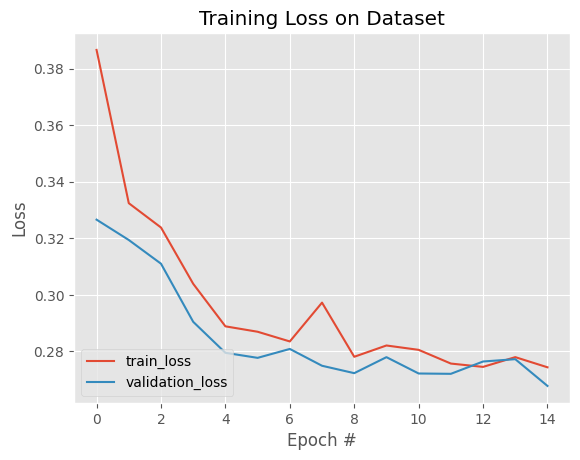

In [21]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["validation_loss"], label="validation_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, NEW_PATH)
